<a href="https://colab.research.google.com/github/tasveebyousaf/NLP_MultiClass_Topic_Classifier_Project/blob/main/TasveebZDV9BS_NLP_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Multi‑Class News Topic Classification on the AG News Dataset Using TF‑IDF, Word2Vec, and Multi‑Model Machine Learning:

This project develops a complete natural language processing (NLP) pipeline for multi‑class news topic classification using the AG News dataset. It takes raw news headlines and descriptions, cleans and tokenizes the text, and transforms it into numerical representations with TF‑IDF and Word2Vec embeddings. On top of these features, the project trains and compares three different models—Multinomial Naive Bayes, Logistic Regression, and a feed‑forward Neural Network—to automatically assign each article to one of four topics: World, Sports, Business, or Sci/Tech. The work includes exploratory data analysis, dimensionality reduction with PCA, rigorous evaluation and benchmarking, simple unit tests, and a Streamlit web application that allows users to interactively classify new articles, demonstrating an end‑to‑end applied machine‑learning workflow.



In [ ]:
!pip install wordcloud gensim streamlit==1.39.0

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import string

from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

from tensorflow import keras
from tensorflow.keras import layers

import gensim
from gensim.models import Word2Vec


In [2]:
from google.colab import files
uploaded = files.upload()


Saving train.csv to train.csv


In [3]:
import pandas as pd

df = pd.read_csv('train.csv')  # name must match exactly
df.head()
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Class Index  120000 non-null  int64 
 1   Title        120000 non-null  object
 2   Description  120000 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.7+ MB


In [ ]:
label_map = {
    1: "World",
    2: "Sports",
    3: "Business",
    4: "Sci/Tech"
}

df['label_name'] = df['Class Index'].map(label_map)
df['text'] = df['Title'].astype(str) + " " + df['Description'].astype(str)
df[['Class Index', 'label_name', 'text']].head()

,Class Index,label_name,text
0,3,Business,Wall St. Bears Claw Back Into the Black (Reute...
1,3,Business,Carlyle Looks Toward Commercial Aerospace (Reu...
2,3,Business,Oil and Economy Cloud Stocks' Outlook (Reuters...
3,3,Business,Iraq Halts Oil Exports from Main Southern Pipe...
4,3,Business,"Oil prices soar to all-time record, posing new..."


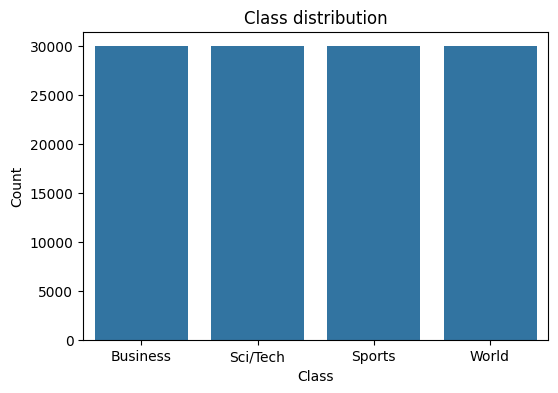

In [ ]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='label_name')
plt.title('Class distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


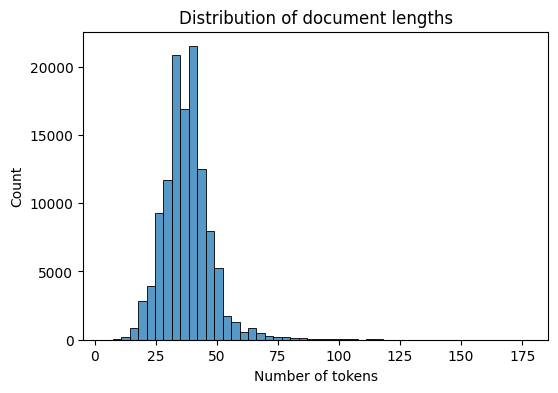

In [ ]:
df['text_len'] = df['text'].str.split().apply(len)

plt.figure(figsize=(6,4))
sns.histplot(df['text_len'], bins=50)
plt.title('Distribution of document lengths')
plt.xlabel('Number of tokens')
plt.show()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


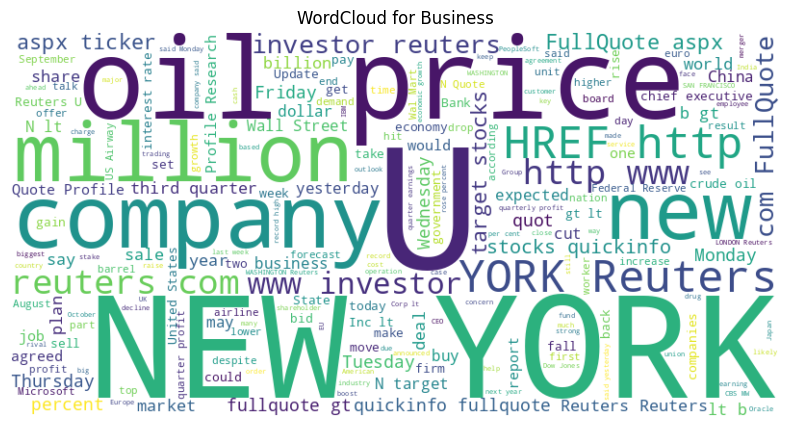

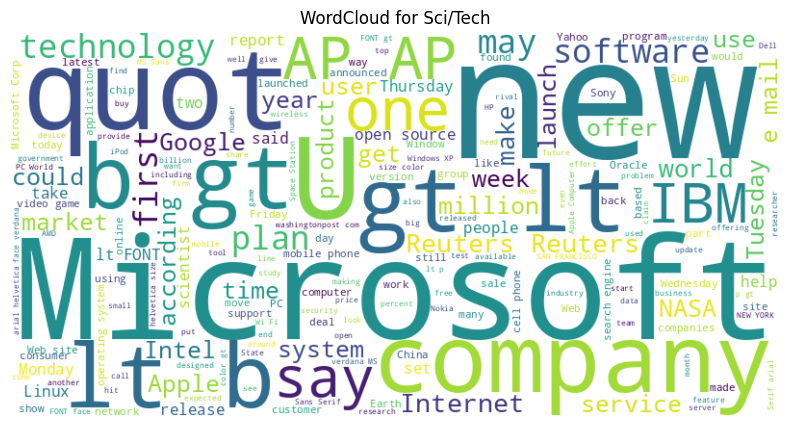

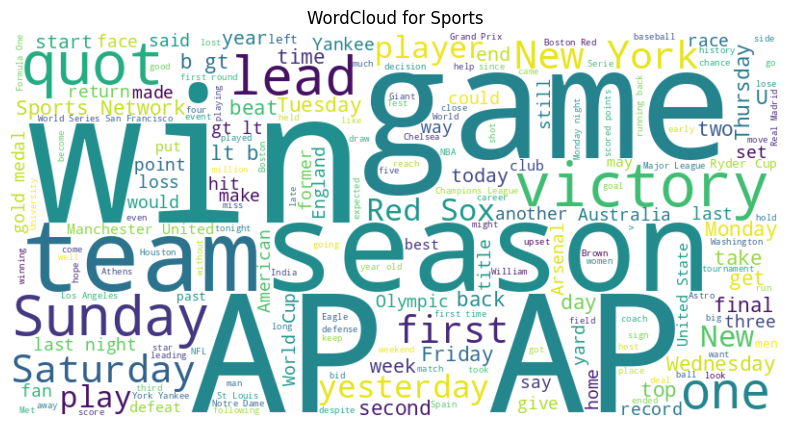

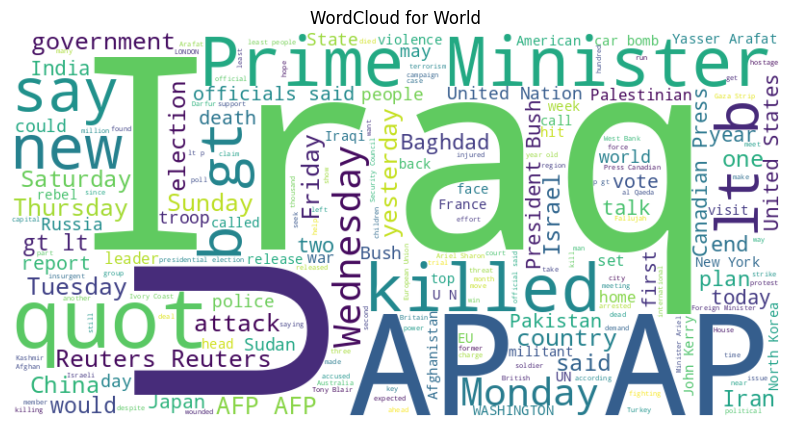

In [ ]:
import nltk
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def generate_wordcloud(text_series, title):
    text = " ".join(text_series)
    wc = WordCloud(
        width=800,
        height=400,
        background_color='white',
        stopwords=stop_words,
        max_words=200
    ).generate(text)
    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

for label in df['label_name'].unique():
    subset = df[df['label_name'] == label]['text']
    generate_wordcloud(subset, f"WordCloud for {label}")

In [ ]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", " ", text)
    text = re.sub(r"\d+", " ", text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = re.sub(r"\s+", " ", text).strip()
    return text


In [ ]:
import nltk
nltk.download('punkt_tab') # Downloading 'punkt_tab' as suggested by the traceback.

df['clean_text'] = df['text'].astype(str).apply(clean_text)

def tokenize(text):
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t not in stop_words]
    return tokens

df['tokens'] = df['clean_text'].apply(tokenize)

df[['text', 'clean_text', 'tokens']].head()

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


,text,clean_text,tokens
0,Wall St. Bears Claw Back Into the Black (Reute...,wall st bears claw back into the black reuters...,"[wall, st, bears, claw, back, black, reuters, ..."
1,Carlyle Looks Toward Commercial Aerospace (Reu...,carlyle looks toward commercial aerospace reut...,"[carlyle, looks, toward, commercial, aerospace..."
2,Oil and Economy Cloud Stocks' Outlook (Reuters...,oil and economy cloud stocks outlook reuters r...,"[oil, economy, cloud, stocks, outlook, reuters..."
3,Iraq Halts Oil Exports from Main Southern Pipe...,iraq halts oil exports from main southern pipe...,"[iraq, halts, oil, exports, main, southern, pi..."
4,"Oil prices soar to all-time record, posing new...",oil prices soar to alltime record posing new m...,"[oil, prices, soar, alltime, record, posing, n..."


In [ ]:
X = df['clean_text']
y = df['label_name']

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

len(X_train), len(X_val), len(X_test)


(96000, 12000, 12000)

In [ ]:
tfidf_vectorizer = TfidfVectorizer(
    max_features=20000,
    ngram_range=(1,2)
)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf   = tfidf_vectorizer.transform(X_val)
X_test_tfidf  = tfidf_vectorizer.transform(X_test)

X_train_tfidf.shape


(96000, 20000)

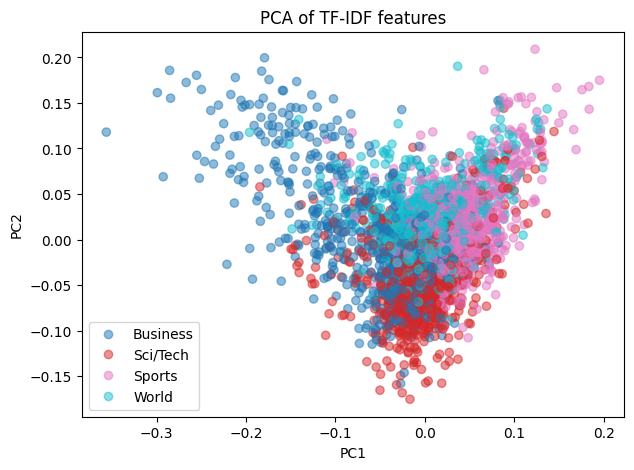

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)

sample_size = 3000
X_sample = X_train_tfidf[:sample_size].toarray()
y_sample = y_train_enc[:sample_size]

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_sample)

plt.figure(figsize=(7,5))
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=y_sample, cmap='tab10', alpha=0.5)
plt.title('PCA of TF-IDF features')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(handles=scatter.legend_elements()[0], labels=list(le.classes_))
plt.show()

In [ ]:
sentences = df['tokens'].tolist()

w2v_model = Word2Vec(
    sentences=sentences,
    vector_size=100,
    window=5,
    min_count=2,
    workers=4,
    sg=1  # skip-gram
)

w2v_model.wv.key_to_index  # vocabulary keys


{'new': 0,
 'said': 1,
 'us': 2,
 'reuters': 3,
 'ap': 4,
 'first': 5,
 'two': 6,
 'world': 7,
 'monday': 8,
 'wednesday': 9,
 'tuesday': 10,
 'oil': 11,
 'thursday': 12,
 'company': 13,
 'one': 14,
 'friday': 15,
 'year': 16,
 'inc': 17,
 'last': 18,
 'york': 19,
 'yesterday': 20,
 'iraq': 21,
 'president': 22,
 'million': 23,
 'microsoft': 24,
 'says': 25,
 'game': 26,
 'united': 27,
 'week': 28,
 'years': 29,
 'prices': 30,
 'corp': 31,
 'could': 32,
 'three': 33,
 'would': 34,
 'sunday': 35,
 'security': 36,
 'time': 37,
 'group': 38,
 'people': 39,
 'government': 40,
 'may': 41,
 'today': 42,
 'afp': 43,
 'percent': 44,
 'quot': 45,
 'software': 46,
 'win': 47,
 'next': 48,
 'back': 49,
 'team': 50,
 'saturday': 51,
 'night': 52,
 'internet': 53,
 'season': 54,
 'deal': 55,
 'sales': 56,
 'second': 57,
 'minister': 58,
 'china': 59,
 'market': 60,
 'day': 61,
 'top': 62,
 'state': 63,
 'billion': 64,
 'announced': 65,
 'business': 66,
 'international': 67,
 'former': 68,
 'killed'

In [ ]:
def document_vector(tokens, model):
    vocab = model.wv.key_to_index
    vecs = [model.wv[word] for word in tokens if word in vocab]
    if len(vecs) == 0:
        return np.zeros(model.vector_size)
    return np.mean(vecs, axis=0)

df['w2v_vec'] = df['tokens'].apply(lambda toks: document_vector(toks, w2v_model))

X_w2v = np.vstack(df['w2v_vec'].values)
X_train_w2v, X_temp_w2v, y_train_w2v, y_temp_w2v = train_test_split(
    X_w2v, y, test_size=0.2, random_state=42, stratify=y
)
X_val_w2v, X_test_w2v, y_val_w2v, y_test_w2v = train_test_split(
    X_temp_w2v, y_temp_w2v, test_size=0.5, random_state=42, stratify=y_temp_w2v
)


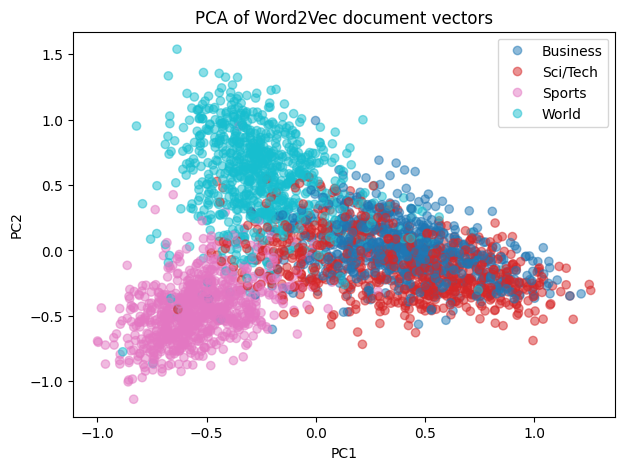

In [ ]:
le_w2v = LabelEncoder()
y_train_w2v_enc = le_w2v.fit_transform(y_train_w2v)

pca_w2v = PCA(n_components=2, random_state=42)
X_w2v_pca = pca_w2v.fit_transform(X_train_w2v[:3000])

plt.figure(figsize=(7,5))
scatter = plt.scatter(X_w2v_pca[:,0], X_w2v_pca[:,1],
                      c=y_train_w2v_enc[:3000], cmap='tab10', alpha=0.5)
plt.title('PCA of Word2Vec document vectors')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(handles=scatter.legend_elements()[0], labels=list(le_w2v.classes_))
plt.show()

In [ ]:
nb_clf = MultinomialNB()
nb_clf.fit(X_train_tfidf, y_train)

y_val_pred_nb = nb_clf.predict(X_val_tfidf)
print("NB validation accuracy:", accuracy_score(y_val, y_val_pred_nb))
print(classification_report(y_val, y_val_pred_nb))


NB validation accuracy: 0.8973333333333333
              precision    recall  f1-score   support

    Business       0.87      0.85      0.86      3000
    Sci/Tech       0.87      0.88      0.87      3000
      Sports       0.94      0.98      0.96      3000
       World       0.91      0.88      0.90      3000

    accuracy                           0.90     12000
   macro avg       0.90      0.90      0.90     12000
weighted avg       0.90      0.90      0.90     12000



In [ ]:
log_reg_clf = LogisticRegression(
    max_iter=1000,
    n_jobs=-1,
    C=2.0
)
log_reg_clf.fit(X_train_tfidf, y_train)

y_val_pred_lr = log_reg_clf.predict(X_val_tfidf)
print("LogReg validation accuracy:", accuracy_score(y_val, y_val_pred_lr))
print(classification_report(y_val, y_val_pred_lr))


LogReg validation accuracy: 0.91425
              precision    recall  f1-score   support

    Business       0.88      0.89      0.89      3000
    Sci/Tech       0.89      0.89      0.89      3000
      Sports       0.96      0.98      0.97      3000
       World       0.92      0.90      0.91      3000

    accuracy                           0.91     12000
   macro avg       0.91      0.91      0.91     12000
weighted avg       0.91      0.91      0.91     12000



In [ ]:
num_classes = len(y_train_w2v.unique())
label_encoder_nn = LabelEncoder()
y_train_nn = label_encoder_nn.fit_transform(y_train_w2v)
y_val_nn   = label_encoder_nn.transform(y_val_w2v)
y_test_nn  = label_encoder_nn.transform(y_test_w2v)

input_dim = X_train_w2v.shape[1]

nn_model = keras.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

nn_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = nn_model.fit(
    X_train_w2v, y_train_nn,
    validation_data=(X_val_w2v, y_val_nn),
    epochs=10,
    batch_size=256,
    verbose=1
)


Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.7797 - loss: 0.6327 - val_accuracy: 0.8967 - val_loss: 0.3024
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8937 - loss: 0.3232 - val_accuracy: 0.9007 - val_loss: 0.2902
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8978 - loss: 0.3083 - val_accuracy: 0.9026 - val_loss: 0.2813
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9017 - loss: 0.2947 - val_accuracy: 0.9049 - val_loss: 0.2780
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9026 - loss: 0.2904 - val_accuracy: 0.9064 - val_loss: 0.2733
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9063 - loss: 0.2803 - val_accuracy: 0.9069 - val_loss: 0.2711
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9049 - loss: 0.2799 - val_accuracy: 0.9070 - val_loss: 0.2667
Epoch 8/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9058 - loss: 0.2780 - val_accuracy: 0

In [ ]:
val_loss, val_acc = nn_model.evaluate(X_val_w2v, y_val_nn, verbose=0)
print("Neural network validation accuracy:", val_acc)


Neural network validation accuracy: 0.9108333587646484


In [ ]:
# Naive Bayes
y_test_pred_nb = nb_clf.predict(X_test_tfidf)
acc_nb = accuracy_score(y_test, y_test_pred_nb)
f1_nb = f1_score(y_test, y_test_pred_nb, average='macro')

# Logistic Regression
y_test_pred_lr = log_reg_clf.predict(X_test_tfidf)
acc_lr = accuracy_score(y_test, y_test_pred_lr)
f1_lr = f1_score(y_test, y_test_pred_lr, average='macro')

# Neural Network
y_test_pred_nn = nn_model.predict(X_test_w2v)
y_test_pred_nn_labels = label_encoder_nn.inverse_transform(
    np.argmax(y_test_pred_nn, axis=1)
)
acc_nn = accuracy_score(y_test_w2v, y_test_pred_nn_labels)
f1_nn = f1_score(y_test_w2v, y_test_pred_nn_labels, average='macro')

results = pd.DataFrame({
    'Model': ['Naive Bayes (TF-IDF)', 'Logistic Regression (TF-IDF)', 'Neural Net (Word2Vec)'],
    'Accuracy': [acc_nb, acc_lr, acc_nn],
    'Macro F1': [f1_nb, f1_lr, f1_nn]
})
results


375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


,Model,Accuracy,Macro F1
0,Naive Bayes (TF-IDF),0.899333,0.899067
1,Logistic Regression (TF-IDF),0.913750,0.913668
2,Neural Net (Word2Vec),0.913250,0.913301


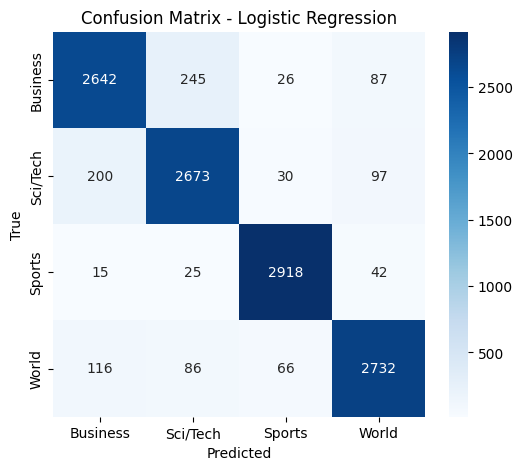

In [ ]:
cm = confusion_matrix(y_test, y_test_pred_lr, labels=log_reg_clf.classes_)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=log_reg_clf.classes_,
            yticklabels=log_reg_clf.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()


In [ ]:
def test_clean_text():
    s = "Hello!!! Visit https://example.com NOW 123"
    cleaned = clean_text(s)
    assert "http" not in cleaned
    assert "123" not in cleaned
    assert cleaned == cleaned.lower()

def test_tfidf_not_empty():
    vec = tfidf_vectorizer.transform(["this is a test"])
    assert vec.nnz > 0  # at least one non-zero entry

def test_nb_predict_shape():
    preds = nb_clf.predict(tfidf_vectorizer.transform(["some random news"]))
    assert len(preds) == 1

test_clean_text()
test_tfidf_not_empty()
test_nb_predict_shape()
print("Basic tests passed.")


Basic tests passed.


In [ ]:
app_code = """
import streamlit as st
import pickle
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer

# Load saved model and vectorizer
with open('tfidf_vectorizer.pkl', 'rb') as f:
    tfidf_vectorizer = pickle.load(f)

with open('best_model.pkl', 'rb') as f:
    model = pickle.load(f)

def main():
    st.title("AG News Topic Classifier")
    st.write("Enter a news headline or short article and get the predicted topic.")

    user_text = st.text_area("News text", height=150)

    if st.button("Classify"):
        if not user_text.strip():
            st.warning("Please enter some text.")
        else:
            cleaned = user_text.lower()
            X = tfidf_vectorizer.transform([cleaned])
            proba = model.predict_proba(X)[0]
            pred = model.predict(X)[0]
            st.subheader(f"Predicted topic: {pred}")
            st.write("Class probabilities:")
            for cls, p in zip(model.classes_, proba):
                st.write(f"{cls}: {p:.3f}")

if __name__ == '__main__':
    main()
"""
with open('app_streamlit.py', 'w') as f:
    f.write(app_code)
print("app_streamlit.py written.")


app_streamlit.py written.


In [ ]:
import pickle

with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)

with open('best_model.pkl', 'wb') as f:
    pickle.dump(log_reg_clf, f)


Limitations:

 Despite strong performance on the AG News dataset, the models are limited to the four predefined topics and may not generalize well to news domains or languages that differ significantly from the training data. They rely mainly on bag‑of‑words style TF‑IDF features and averaged Word2Vec embeddings, which ignore word order and long‑range context, so they can struggle with subtle meanings, sarcasm, or articles where topic cues are weak or ambiguous. In addition, the project uses relatively simple architectures and modest hyperparameter tuning; more advanced transformer‑based models (such as BERT) and larger, carefully curated training sets could likely achieve higher accuracy and more robust performance.

Conclusion:

This project shows how to build a full, academically sound NLP pipeline for news topic classification, starting from raw AG News text and ending with a usable web application. Through systematic preprocessing, dual feature‑extraction strategies, and multiple models, it demonstrates how design choices affect performance and highlights the strengths of linear classifiers with TF‑IDF features for this task. The comparative evaluation and visualizations provide insight into model behavior and error patterns, while the Streamlit app and unit‑test checks illustrate how to package and validate a machine‑learning system for practical use and future extension.